In [1]:
library(dplyr)
library(ggplot2)
library(Seurat)
library(TFBSTools)
library(presto)
library(motifmatchr)
library(qlcMatrix)
library(scCustomize)
library(RColorBrewer)
library(ggrepel)
library(patchwork)
library(tidydr)
library(GenomicRanges)
library(Signac)
library(zoo)
library(ComplexHeatmap)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(chromVAR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:TFBSTools’:

    Matrix


Loading required package: slam


Attaching package: ‘slam’


The following object is masked from ‘package:data.table’:

    rollup


Loading required package: sparsesvd

scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.ht

# data process

In [2]:
# Load data ####
seu_rna <- readRDS('./03_Skin/RNA/Mskin_rna.rds')
seu_atac <- readRDS('./03_Skin/Mskin_atac.rds')

In [3]:
# atac data re-annotation
Idents(object = seu_atac) <- "ATAC_snn_res.0.8"
levels(seu_atac) <- c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14','15','16','17','18',
                      '19','20','21','22','23','24','25','26','27','28','29','30','31','32','33')
new.cluster.ids <- c('Basal', 'Basal', 'Fibroblasts', 'Spinous', 'Fibroblasts', 'Fibroblasts', 'Basal', 'Spinous',
                     'Basal', 'Basal', 'Basal', 'Fibroblasts', 'Basal', 'Fibroblasts', 'Mast_cells','Cycling', 'Chod', 
                     'Fibroblasts', 'Vascular_endothelium', 'Neural crest', 'Muscle', 'Mac','Chod', 'Fibroblasts', 'Periderm', 'Fibroblasts', 'Dermal_Papilla', 'Chod',
                    'Schwann', 'Melanocytes', 'Basal', 'Fibroblasts', 'Lymphatic_endothelium','Basal')
names(new.cluster.ids) <- levels(seu_atac)
seu_atac <- RenameIdents(seu_atac, new.cluster.ids)
# 
seu_atac$celltype=Idents(seu_atac)
seu_atac$celltype <- factor(seu_atac$celltype, levels=c('Basal', 'Spinous','Fibroblasts', 'Chod', 'Dermal_Papilla', 'Cycling','Vascular_endothelium', 'Lymphatic_endothelium', 'Muscle', 'Melanocytes', 'Schwann','Mast_cells', 'Mac', 'Neural crest','Periderm'))
# saveRDS(seu_atac,'./03_Skin/Mskin_atac.rds')

* RNA&ATAC integration

In [4]:
seu_rna <- readRDS('./03_Skin/RNA/Mskin_rna.rds')
seu_atac <- readRDS('./03_Skin/Mskin_atac.rds')

In [5]:
seu_rna
seu_atac
colnames(seu_rna@meta.data)
colnames(seu_atac@meta.data)
granges(seu_atac)

An object of class Seurat 
28250 features across 64408 samples within 1 assay 
Active assay: RNA (28250 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
196911 features across 64408 samples within 2 assays 
Active assay: ATAC (175103 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 3 dimensional reductions calculated: integrated_lsi, umap.atac, umap

[1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "batch"             "percent.mt"        "percent.ribo"     
 [7] "percent_mito"      "percent_ribo"      "percent_mito_ribo"
[10] "log10GenesPerUMI"  "outlier"           "scDblFinder.class"
[13] "scDblFinder.score" "RNA_snn_res.0.1"   "RNA_snn_res.0.3"  
[16] "RNA_snn_res.0.5"   "seurat_clusters"   "predicted.id"     
[19] "celltype"          "RNA_snn_res.0.8"   "RNA_snn_res.1"    
[22] "RNA_snn_res.2"     "stage"             "RNA_snn_res.0.6"  
[25] "RNA_snn_res.0.7"

[1] "orig.ident"            "nCount_ATAC"           "nFeature_ATAC"        
 [4] "TSS.enrichment"        "TSS.percentile"        "nucleosome_signal"    
 [7] "nucleosome_percentile" "fragments"             "FRiP"                 
[10] "blacklist_fraction"    "ATAC_snn_res.0.8"      "seurat_clusters"      
[13] "scDblFinder.class"     "scDblFinder.score"     "ATAC_snn_res.0.1"     
[16] "ATAC_snn_res.0.3"      "ATAC_snn_res.0.5"      "nCount_RNA"           
[19] "nFeature_RNA"          "predicted.id"          "celltype"

GRanges object with 175103 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3094494-3095551      *
       [2]     chr1   3119700-3120272      *
       [3]     chr1   3132253-3132484      *
       [4]     chr1   3252709-3252918      *
       [5]     chr1   3268417-3268746      *
       ...      ...               ...    ...
  [175099]     chrY 90803161-90803753      *
  [175100]     chrY 90804818-90805256      *
  [175101]     chrY 90807495-90807910      *
  [175102]     chrY 90810897-90811155      *
  [175103]     chrY 90811361-90813122      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

In [6]:
# 整合为一个文件
seu=seu_rna
# 
seu[['ATAC']]=seu_atac[['ATAC']]
seu[['aRNA']]=seu_atac[['RNA']]
seu[['integrated_lsi']]=seu_atac[['integrated_lsi']]
seu[['umap.atac']]=seu_atac[['umap.atac']]
seu$ATAC_snn_res.0.1=seu_atac$ATAC_snn_res.0.1
seu$ATAC_snn_res.0.3=seu_atac$ATAC_snn_res.0.3
seu$ATAC_snn_res.0.5=seu_atac$ATAC_snn_res.0.5
seu$ATAC_snn_res.0.8=seu_atac$ATAC_snn_res.0.8
seu$nCount_ATAC=seu_atac$nCount_ATAC
seu$nFeature_ATAC=seu_atac$nFeature_ATAC
seu[['atac_celltype']]=seu_atac[['celltype']]
colnames(seu@meta.data)[colnames(seu@meta.data) == "celltype"] <- 'rna_celltype'
# Add stage of mouse embryonic development
seu@meta.data$stage <- sapply(strsplit(seu$orig.ident,"_"), "[", 1)

Warning message:
“Key ‘rna_’ taken, using ‘arna_’ instead”


In [7]:
seu
colnames(seu@meta.data)
head(seu@meta.data)

An object of class Seurat 
225161 features across 64408 samples within 3 assays 
Active assay: RNA (28250 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ATAC, aRNA
 5 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac

[1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "batch"             "percent.mt"        "percent.ribo"     
 [7] "percent_mito"      "percent_ribo"      "percent_mito_ribo"
[10] "log10GenesPerUMI"  "outlier"           "scDblFinder.class"
[13] "scDblFinder.score" "RNA_snn_res.0.1"   "RNA_snn_res.0.3"  
[16] "RNA_snn_res.0.5"   "seurat_clusters"   "predicted.id"     
[19] "rna_celltype"      "RNA_snn_res.0.8"   "RNA_snn_res.1"    
[22] "RNA_snn_res.2"     "stage"             "RNA_snn_res.0.6"  
[25] "RNA_snn_res.0.7"   "ATAC_snn_res.0.1"  "ATAC_snn_res.0.3" 
[28] "ATAC_snn_res.0.5"  "ATAC_snn_res.0.8"  "nCount_ATAC"      
[31] "nFeature_ATAC"     "atac_celltype"

,orig.ident,nCount_RNA,nFeature_RNA,batch,percent.mt,percent.ribo,percent_mito,percent_ribo,percent_mito_ribo,log10GenesPerUMI,⋯,stage,RNA_snn_res.0.6,RNA_snn_res.0.7,ATAC_snn_res.0.1,ATAC_snn_res.0.3,ATAC_snn_res.0.5,ATAC_snn_res.0.8,nCount_ATAC,nFeature_ATAC,atac_celltype
,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
E13_HU1_BC0077_N02,E13_HU1,8225.5861,4418,E13_HU1,0.4983267,0.4492322,0.4983267,0.4492322,0.9475589,0.9310525,⋯,E13,11,11,6,12,16,18,17521,10364,Vascular_endothelium
E13_HU1_BC0125_N01,E13_HU1,2257.2644,1467,E13_HU1,1.0910011,0.8912272,1.0910011,0.8912272,1.9822283,0.9441933,⋯,E13,11,11,6,12,16,18,15484,9871,Vascular_endothelium
E13_HU1_BC0143_N03,E13_HU1,4146.4758,2963,E13_HU1,0.3926366,0.6564099,0.3926366,0.6564099,1.0490466,0.9596572,⋯,E13,8,8,9,14,19,19,12236,8554,Neural crest
E13_HU1_BC0146_N02,E13_HU1,2343.9995,1521,E13_HU1,1.5682774,0.9950857,1.5682774,0.9950857,2.5633631,0.9442639,⋯,E13,3,3,2,17,23,24,11163,7686,Periderm
E13_HU1_BC0156_N01,E13_HU1,4617.5425,2426,E13_HU1,1.0246861,1.7786067,1.0246861,1.7786067,2.8032929,0.9237203,⋯,E13,0,0,0,0,1,1,19588,13531,Basal
E13_HU1_BC0158_N02,E13_HU1,951.0275,783,E13_HU1,0.5530716,0.6850751,0.5530716,0.6850751,1.2381467,0.9716502,⋯,E13,9,9,1,2,20,13,7639,5675,Fibroblasts


In [8]:
# wnn
seu <- FindMultiModalNeighbors(seu, reduction.list = list("harmony", "integrated_lsi"), dims.list = list(1:40, 2:40))
seu <- RunUMAP(seu, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
seu <- FindClusters(seu, graph.name = "wsnn", algorithm = 3, resolution = c(0.1, 0.3, 0.5), verbose = FALSE)
# saveRDS(seu,'./03_Skin/Mskin_rna_atac.rds')

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Loading required package: Signac


Attaching package: ‘Signac’


The following object is masked from ‘package:qlcMatrix’:

    corSparse


Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:16:19 UMAP embedding parameters a = 0.9922 b = 1.112

16:16:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

16:16:30 Initializing from normalized Laplacian + noise (using RSpectra)

16:16:46 Commencing optimization for 200 epochs, with 2083772 positive edges

16:18:52 Optimization finished



* add chromVAR and SCT

In [9]:
seu <- readRDS('./03_Skin/Mskin_rna_atac.rds')
seu

An object of class Seurat 
225161 features across 64408 samples within 3 assays 
Active assay: RNA (28250 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ATAC, aRNA
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap

In [10]:
# SCT
DefaultAssay(seu) <- "RNA"
seu <- SCTransform(seu, vars.to.regress = "percent.mt", verbose = FALSE)
# chromVAR
DefaultAssay(seu) <- "ATAC"
pfm <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE))
seu <- AddMotifs(object = seu, genome = BSgenome.Mmusculus.UCSC.mm10, pfm = pfm)
seu <- RunChromVAR(object = seu, genome = BSgenome.Mmusculus.UCSC.mm10)
# saveRDS(seu,'./03_Skin/Mskin_rna_atac_process.rds')

Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



## peak2gene linkage

In [11]:
# downsample 
sample <- unlist(lapply(unique(seu$rna_celltype),function(x){ 
        cell <- colnames(seu)[seu$rna_celltype==x]
        if(length(cell)>2000){sample(cell,2000)} else {cell}
}))
seu <- seu[,sample]

Loading required package: Signac


Attaching package: ‘Signac’


The following object is masked from ‘package:qlcMatrix’:

    corSparse




In [12]:
markers_rna <- presto:::wilcoxauc.Seurat(seu, group_by = 'rna_celltype', assay = 'data', seurat_assay = 'SCT')
markers_motifs <- presto:::wilcoxauc.Seurat(seu, group_by = 'rna_celltype', assay = 'data', seurat_assay = 'chromvar')
colnames(markers_rna) <- paste0("RNA.", colnames(markers_rna))
colnames(markers_motifs) <- paste0("motif.", colnames(markers_motifs))
markers_rna$gene <- markers_rna$RNA.feature
DefaultAssay(seu) <- 'ATAC'
markers_motifs$gene <- ConvertMotifID(seu, id = markers_motifs$motif.feature)

In [13]:
head(markers_motifs)

,motif.feature,motif.group,motif.avgExpr,motif.logFC,motif.statistic,motif.auc,motif.pval,motif.padj,motif.pct_in,motif.pct_out,gene
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,MA0004.1,Basal,-0.4484902,-0.9479042,9020043,0.3018150,8.318413e-183,2.433544e-182,100,100,Arnt
2,MA0006.1,Basal,-0.7096958,-1.2615870,7338404,0.2455466,5.662603e-300,2.211676e-299,100,100,Ahr::Arnt
3,MA0019.1,Basal,-0.1305416,-0.1893600,13477392,0.4509600,9.710607e-13,1.142605e-12,100,100,Ddit3::Cebpa
4,MA0029.1,Basal,0.3298310,0.2362740,17583930,0.5883668,7.959904e-38,1.141940e-37,100,100,Mecom
5,MA0030.1,Basal,-0.2121485,-0.6292516,10751039,0.3597350,1.467648e-92,2.873663e-92,100,100,FOXF2
6,MA0031.1,Basal,-0.1451939,-0.5285670,11617656,0.3887324,6.158341e-59,1.011921e-58,100,100,FOXD1


In [14]:
# additional processing 
library(tidyr)
markers_motifs$gene <- gsub("\\(var.2)|\\(var.3)","",markers_motifs$gene)
markers_motifs <- markers_motifs %>% 
        mutate(gene = strsplit(gene, "::")) %>% 
        unnest(gene)
markers_motifs <- data.frame(markers_motifs)
markers_motifs$gene <- unlist(lapply(markers_motifs$gene,function(x){
        paste0(toupper(substr(x, 1, 1)), tolower(substr(x, 2, nchar(x))))
}))
topTFs <- function(rna_celltype, padj.cutoff = 0.05) {
        ctmarkers_rna <- dplyr::filter(
                markers_rna, RNA.group == rna_celltype, RNA.padj < padj.cutoff, RNA.logFC > 0) %>% 
                arrange(-RNA.auc)
        ctmarkers_motif <- dplyr::filter(
                markers_motifs, motif.group == rna_celltype, motif.padj < padj.cutoff, motif.logFC > 0) %>% 
                arrange(-motif.auc)
        top_tfs <- inner_join(
                x = ctmarkers_rna[, c(2, 11, 6, 7)], 
                y = ctmarkers_motif[, c(2, 1, 11, 6, 7)], by = "gene"
        )
        top_tfs$avg_auc <- (top_tfs$RNA.auc + top_tfs$motif.auc) / 2
        top_tfs <- arrange(top_tfs, -avg_auc)
        return(top_tfs)
}
head(topTFs("Basal"), 3)


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




,RNA.group,gene,RNA.auc,RNA.pval,motif.group,motif.feature,motif.auc,motif.pval,avg_auc
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Basal,Lef1,0.7316685,0.000000e+00,Basal,MA0768.1,0.8266595,0,0.7791640
2,Basal,Tfap2b,0.6189092,3.080136e-186,Basal,MA0811.1,0.8949145,0,0.7569119
3,Basal,Tfap2b,0.6189092,3.080136e-186,Basal,MA0812.1,0.8786599,0,0.7487846


In [15]:
# Find DEGs bw clusters ####
DefaultAssay(seu) <- "SCT"
Idents(seu) <- seu$rna_celltype
de_genes <- FindAllMarkers(seu,only.pos = T,logfc.threshold = 0.1,max.cells.per.ident = 1000)

Calculating cluster Basal

Calculating cluster Spinous

Calculating cluster Fibroblasts

Calculating cluster Chod

Calculating cluster Dermal_papilla

Calculating cluster Cycling

Calculating cluster Vascular_endothelium

Calculating cluster Lymphatic_endothelium

Calculating cluster Muscle

Calculating cluster Melanocytes

Calculating cluster Schwann

Calculating cluster Mast_cells

Calculating cluster Mac

Calculating cluster Neural_crest

Calculating cluster Periderm



In [16]:
# Linking peaks to genes ####
DefaultAssay(seu) <- "ATAC"
seu <- RegionStats(seu, genome = BSgenome.Mmusculus.UCSC.mm10)
deg <- unique(de_genes[de_genes$p_val_adj<0.05 & de_genes$avg_log2FC>0.1,'gene'])
seu <- LinkPeaks(seu,peak.assay = "ATAC",expression.assay = "SCT",genes.use = deg) 
link <- Links(seu)
link <- data.frame(link)
link$adj_pval <- p.adjust(link$pvalue,method = 'BH')
link$gene_cluster <- de_genes[match(link$gene,de_genes$gene),'cluster']
lvl <- levels(seu)
link <- arrange(link,factor(gene_cluster,levels=lvl))
link <- link[link$adj_pval<0.05 & link$score>0,]
t <- link %>% group_by(gene) %>% summarise(n=n())
summary(t$n)
# saveRDS(seu,'./03_Skin/Mskin_rna_atac_link.rds')

Testing 5299 genes and 174808 peaks

Found gene coordinates for 4901 genes



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   4.743   6.000  39.000 

# marker/cluster annotation

In [17]:
seu <- readRDS('./03_Skin/Mskin_rna_atac_process.rds')

In [18]:
head(seu@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,batch,percent.mt,percent.ribo,percent_mito,percent_ribo,percent_mito_ribo,log10GenesPerUMI,⋯,nFeature_aRNA,ATAC_snn_res.0.1,ATAC_snn_res.0.3,ATAC_snn_res.0.5,stage,RNA.weight,ATAC.weight,wsnn_res.0.1,wsnn_res.0.3,wsnn_res.0.5
,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>
E13_HU1_BC0077_N02,E13_HU1,8225.5861,4418,E13_HU1,0.4983267,0.4492322,0.4983267,0.4492322,0.9475589,0.9310525,⋯,8925,6,12,16,E13,0.411893229,0.5881068,7,12,15
E13_HU1_BC0125_N01,E13_HU1,2257.2644,1467,E13_HU1,1.0910011,0.8912272,1.0910011,0.8912272,1.9822283,0.9441933,⋯,6559,6,12,16,E13,0.191441473,0.8085585,7,12,15
E13_HU1_BC0143_N03,E13_HU1,4146.4758,2963,E13_HU1,0.3926366,0.6564099,0.3926366,0.6564099,1.0490466,0.9596572,⋯,9211,9,14,19,E13,0.470461757,0.5295382,9,13,25
E13_HU1_BC0158_N02,E13_HU1,951.0275,783,E13_HU1,0.5530716,0.6850751,0.5530716,0.6850751,1.2381467,0.9716502,⋯,6284,1,2,20,E13,0.008622857,0.9913771,1,3,12
E13_HU1_BC0220_N01,E13_HU1,1977.7952,1548,E13_HU1,0.3769382,0.6219195,0.3769382,0.6219195,0.9988577,0.9677171,⋯,6943,3,3,5,E13,0.640909716,0.3590903,9,13,16
E13_HU1_BC0228_N01,E13_HU1,954.3767,835,E13_HU1,0.6426990,0.3415678,0.6426990,0.3415678,0.9842668,0.9805239,⋯,4850,3,3,5,E13,0.141247067,0.8587529,3,5,6


In [19]:
#figure3 RNA use maker
featureSets <- list(
    'Basal'= c('Krt5', "Col17a1",'Krt15'),
    'Spinous'= c('Krt1', 'Krt10'),
    'Fibroblasts' = c("Col1a1",'Pdgfra','Lum','Dcn','Col1a2'),
    'Chod'=c('Sox9','Col2a1','Col9a3','Acan'),
    'Dermal_papilla'= c("Bmp7", "Hhip", "Apcdd1"),
    'Cycling'= c("Mki67","Top2a"),
    'Vascular_endothelium'= c( 'Pecam1','Cdh5'),
    'Lymphatic_endothelium'= c("Flt4", "Lyve1",'Prox1'),
    'Muscle' = c('Tagln','Acta2','Rgs5'), 
    'Melanocytes' = c("Mitf", "Sox10", "Mlana"),
    'Schwann' = c('Pax3', 'Itgb8', 'Scn7a','Plp1'),
    "Mast_cells" = c("Kit", "Tpsb2", 'Cpa3', 'Il1rl1'),
    "Mac" = c('Cd14','Cd163','C1qb', 'Itgax'),
    #'Erythrocyte'= c('Hba-a1', 'Hba-a2'),
    'Neural_crest' = c('Ppp1r1c', 'Syt13', 'Ptprr', 'Pcbp3'),
    'Periderm' = c('Myh14','Krt17','Grhl3')
)
markerlist <- unique(unlist(featureSets)) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


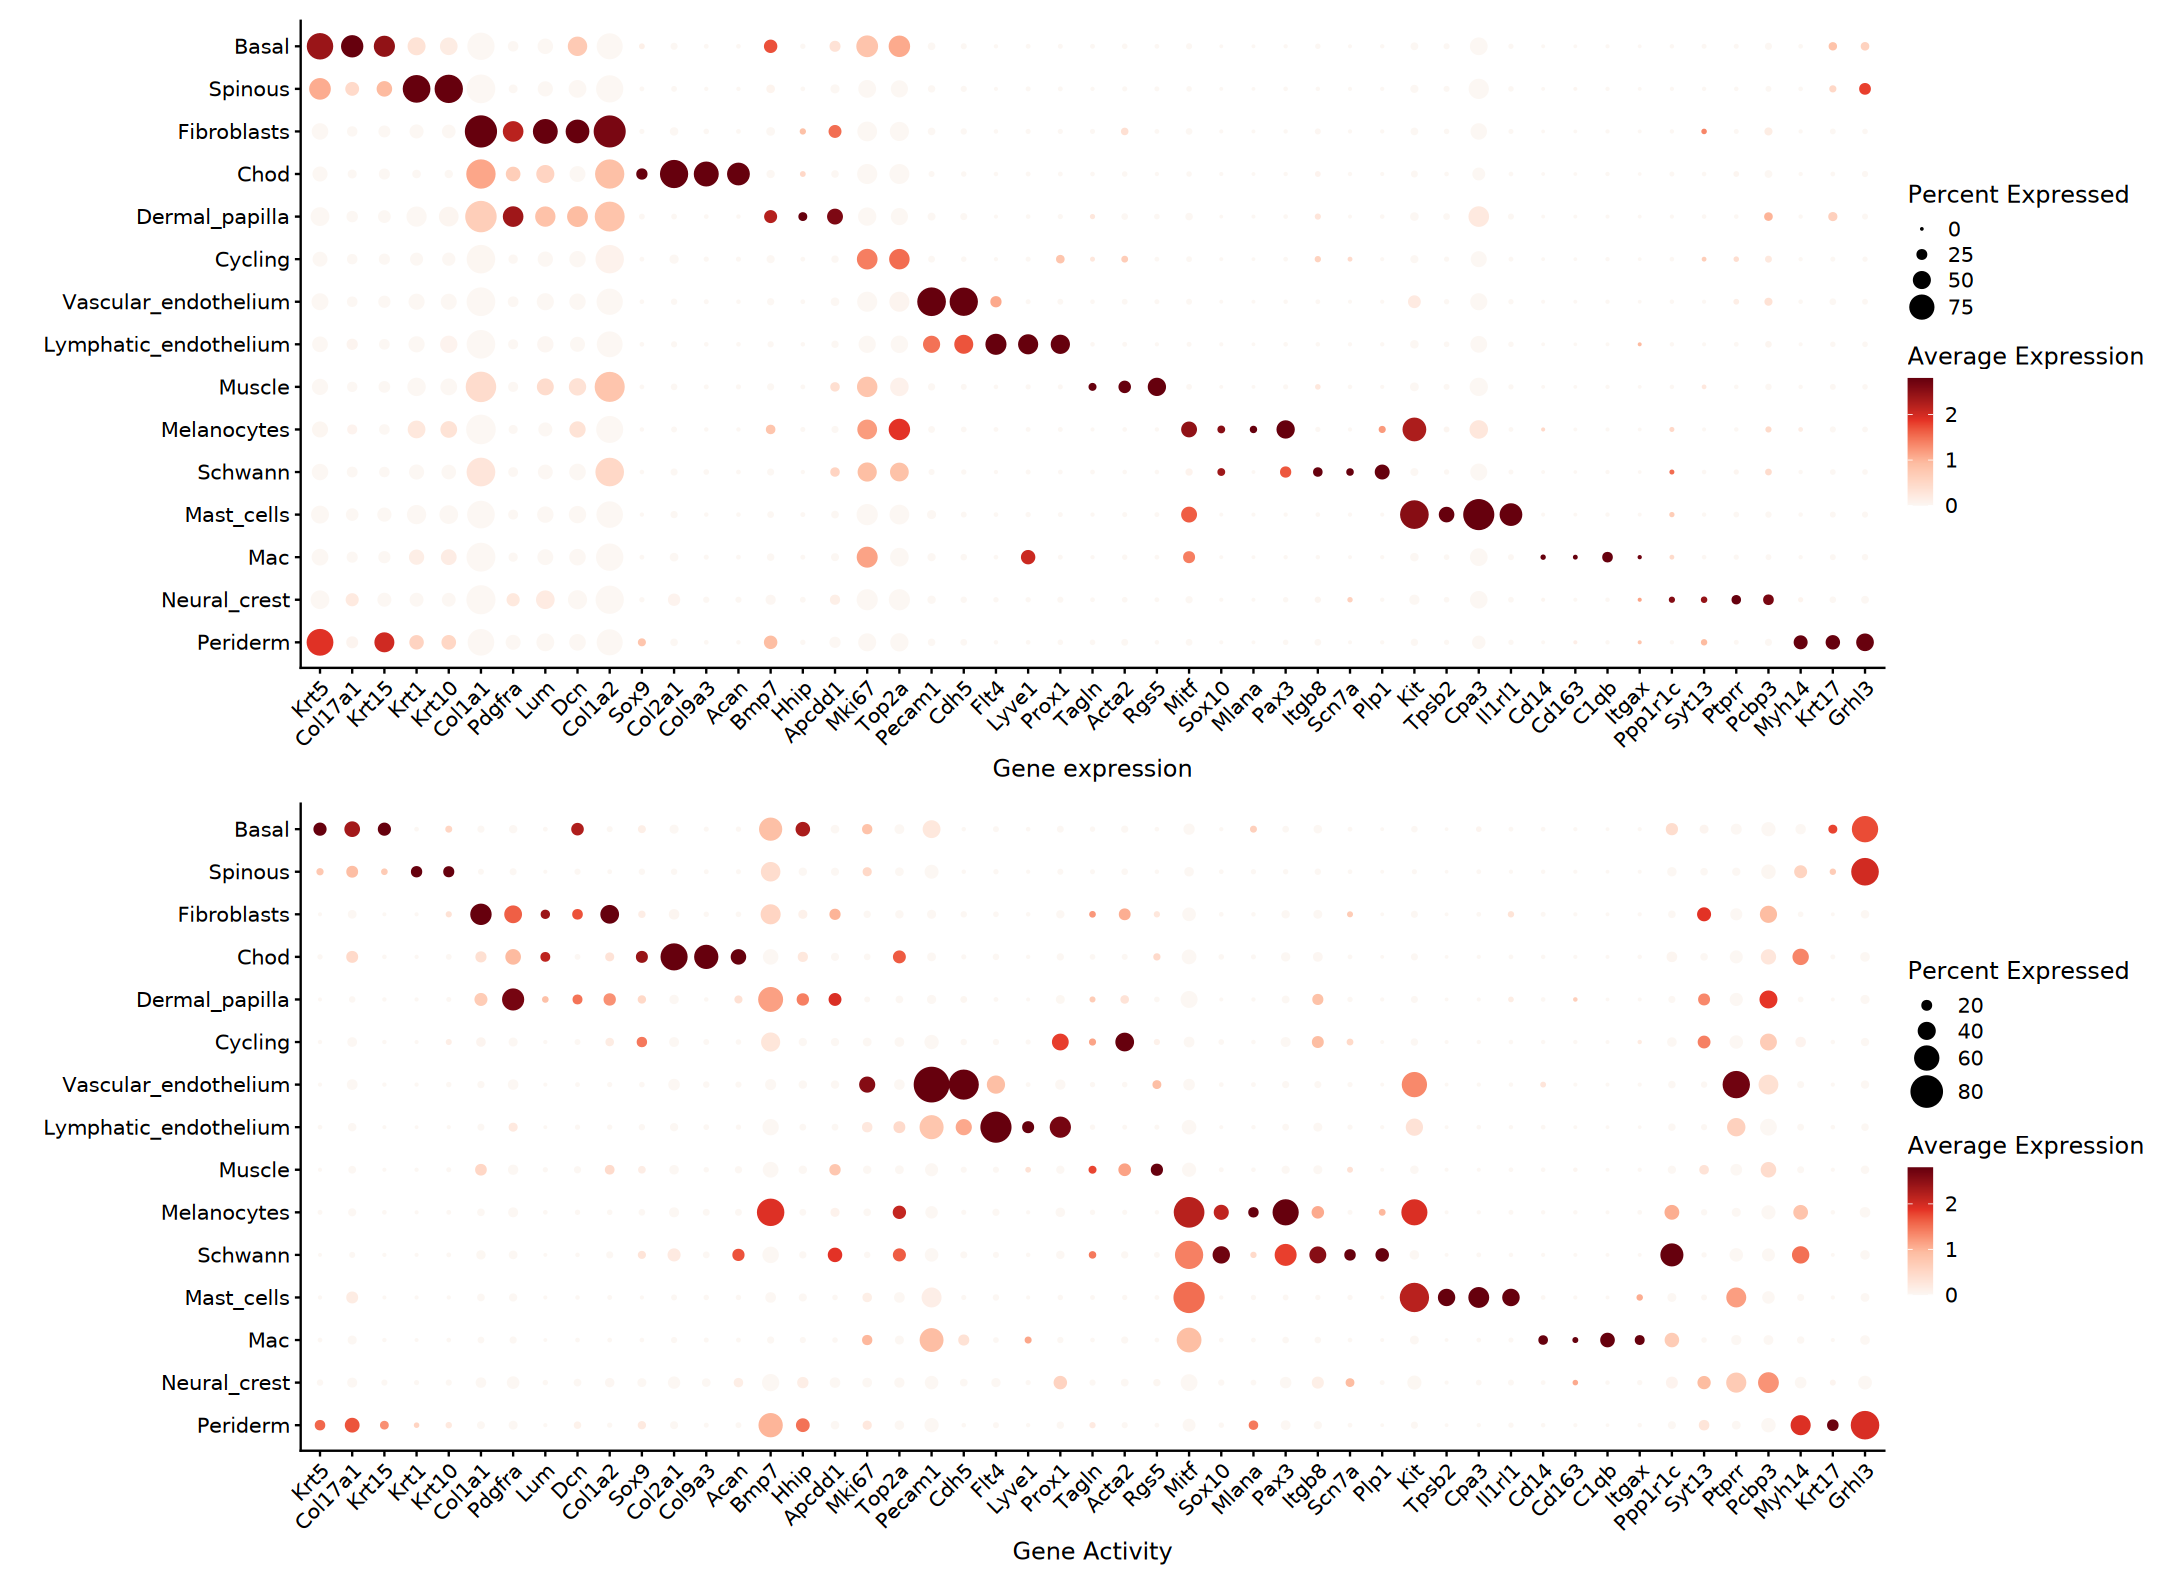

In [20]:
Idents(object = seu) <- "rna_celltype"
options(repr.plot.width=18, repr.plot.height=13.2)
#figure3 RNA use maker
DefaultAssay(seu) <- 'RNA'
p1 <- Seurat::DotPlot(seu, features = markerlist, group.by='rna_celltype', scale = TRUE, cluster.idents=FALSE, col.min = 0,col.max = 2.8, dot.scale=8) + RotatedAxis() + 
     scale_color_gradientn(colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 189/255, 162/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255))) + #(colours = c(rgb(252/255, 247/255, 243/255),rgb(237/255, 213/255, 192/255),rgb(224/255, 147/255, 121/255),rgb(176/255, 49/255, 51/255),rgb(81/255, 24/255, 29/255)))
     xlab('Gene expression') + ylab('') + scale_y_discrete(limits=rev(levels(seu))) + scale_x_discrete(limits=markerlist)
DefaultAssay(seu) <- 'aRNA'
p2 <- Seurat::DotPlot(seu, features = markerlist, group.by='rna_celltype', scale = TRUE, cluster.idents=FALSE, col.min = 0,col.max = 2.8, dot.scale=9) + RotatedAxis() + 
     scale_color_gradientn(colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 189/255, 162/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255))) + #(colours = c(rgb(252/255, 247/255, 243/255),rgb(237/255, 213/255, 192/255),rgb(224/255, 147/255, 121/255),rgb(176/255, 49/255, 51/255),rgb(81/255, 24/255, 29/255)))
     xlab('Gene Activity') + ylab('') + scale_y_discrete(limits=rev(levels(seu))) + scale_x_discrete(limits=markerlist)
p1/p2
ggsave('./03_Skin/Mskin_marker_Plot.pdf',p1/p2,width=18,height=13.2,dpi=600)